# Model Training

This notebook holds a proof of concept of how the CreditKarma Scorer model would be trained using the gold table. CreditKarma Scorer is a binary classification logistic regression model that outputs the **probability of a customer defaulting their loan**. Loaning decisions are made by setting a threshold probability based on **F2-score**, as we want to be conservative in giving out loans and prioritize low-risk individuals (i.e. minimize false negatives from CreditKarma Scorer, which rates a high risk individual as low risk).

In [58]:
import os
import glob
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import pyspark

from tqdm import tqdm

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, fbeta_score, confusion_matrix, ConfusionMatrixDisplay
import numpy as np

import pickle


**Import data from gold table**

In [59]:
spark = pyspark.sql.SparkSession.builder \
    .appName("model-training") \
    .master("local[*]") \
    .getOrCreate()

In [60]:
def read_gold_table(subset, table, gold_db, spark):
    """
    Helper function to read all partitions of a gold table
    """
    folder_path = os.path.join(gold_db, table, subset)
    files_list = [os.path.join(folder_path, os.path.basename(f)) for f in glob.glob(os.path.join(folder_path, '*'))]
    df = spark.read.option("header", "true").parquet(*files_list)
    return df


In [61]:
X_train = read_gold_table('train', 'feature_store', 'datamart/gold', spark)
y_train = read_gold_table('train', 'label_store', 'datamart/gold', spark)
X_test = read_gold_table('test', 'feature_store', 'datamart/gold', spark)
y_test = read_gold_table('test', 'label_store', 'datamart/gold', spark)

In [62]:
X_train_df = X_train.toPandas().sort_values(by='customer_id')
y_train_df = y_train.toPandas().sort_values(by='customer_id')
X_test_df = X_test.toPandas().sort_values(by='customer_id')
y_test_df = y_test.toPandas().sort_values(by='customer_id')

In [63]:
X_train_arr = X_train_df.drop(columns=['customer_id', 'snapshot_date']).values
y_train_arr = y_train_df["label"].values

X_test_arr = X_test_df.drop(columns=['customer_id', 'snapshot_date']).values
y_test_arr = y_test_df["label"].values

**Train CreditKarma Scorer**

In [47]:
# Train model
clf = LogisticRegression()
clf.fit(X_train_arr, y_train_arr)

# Save model
with open("model.pkl", "wb") as f:
    pickle.dump(clf, f)

**Evaluate CreditKarma Scorer**

In [64]:
# Load model
with open("model.pkl", "rb") as f:
    clf = pickle.load(f)

In [65]:
# Predict and evaluate
y_pred_proba = clf.predict_proba(X_test_arr)[:, 1]
auc = roc_auc_score(y_test_arr, y_pred_proba)
print(f"AUC: {auc:.4f}")

AUC: 0.9220


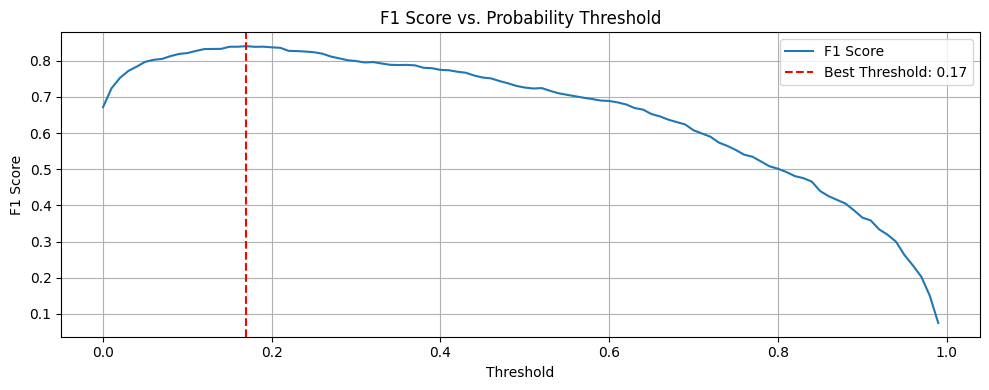

In [66]:
# F2 score across thresholds
thresholds = np.arange(0.0, 1.0, 0.01)
f1_scores = [fbeta_score(y_test_arr, y_pred_proba > t, beta=2) for t in thresholds]
best_threshold = thresholds[np.argmax(f1_scores)]

# Plot F1 Score vs. Threshold
plt.figure(figsize=(10, 4))
plt.plot(thresholds, f1_scores, label="F1 Score")
plt.axvline(x=best_threshold, color="red", linestyle="--", label=f"Best Threshold: {best_threshold:.2f}")
plt.title("F1 Score vs. Probability Threshold")
plt.xlabel("Threshold")
plt.ylabel("F1 Score")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

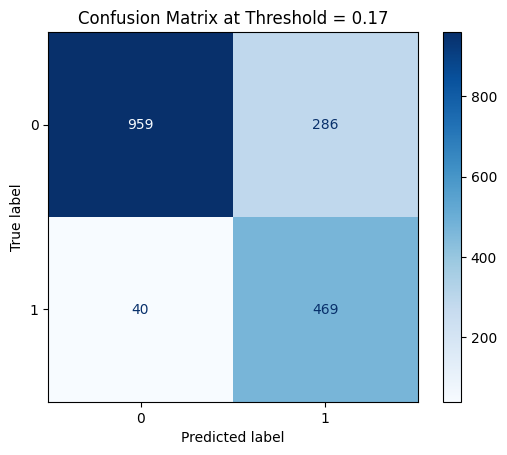

In [67]:
# Confusion matrix at best threshold
y_pred = (y_pred_proba > best_threshold).astype(int)
cm = confusion_matrix(y_test_arr, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap="Blues")
plt.title(f"Confusion Matrix at Threshold = {best_threshold:.2f}")
plt.grid(False)
plt.show()